In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


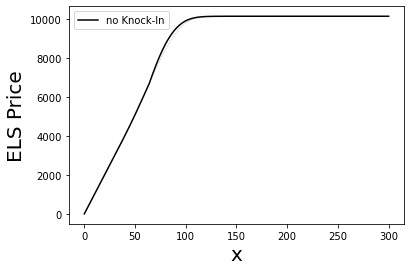

Price=9899.781594


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import thomas as tho

facevalue = 10000 #액면금액
R = 300 # x,y 도메인의 최댓값
volatility = 0.1778 # 변동성
r = 0.0165 # 무위험 이자율
Nx = 301 # 공간격자갯수
h = R/Nx # 공간격자간격
x0 = 100 # 최초 기준 가격
x = np.linspace(0, R, Nx) # 기초자산
T = 3 # 만기
Nt = 360*T # 시간격자갯수
dt = T/Nt # 시간격자간격
# 낙인 아래로 떨어지지 않는 경우 옵션가격 행렬 생성, 모두 0임
u = np.zeros((Nx, Nt+1))
# 낙인 아래로 떨어진 경우 옵션가격 행렬 생성, 모두 0임
ku = np.zeros((Nx, Nt+1))
#조기상환시 쿠폰 이자율
coupon_rate = np.array([0.132, 0.11, 0.088, 0.066, 0.044, 0.022])
#조기행사가
strike_price = np.array([0.85, 0.90, 0.90, 0.95, 0.95, 0.95])
# 조기행사 시점 벡터
step = np.array([np.rint(Nt/6), np.rint(2*Nt/6), np.rint(3*Nt/6), np.rint(4*Nt/6), np.rint(5*Nt/6), Nt+1])
dummy = 0.132 # 더미 이자율
kib = 0.65 # 낙인 배리어
# 유한 차분법으로 ELS 가격을 구하기 위한 초깃값
for i in range(0, Nx):
    if(x[i] < kib*x0):
        u[i,0] = x[i]/x0*facevalue
        ku[i,0] = x[i]/x0*facevalue
    elif(x[i] < strike_price[0]*x0):
        u[i,0] = facevalue*(1+dummy)
        ku[i,0] = x[i]/x0*facevalue
    else:
        u[i,0] = facevalue*(1+coupon_rate[0])
        ku[i,0] = facevalue*(1+coupon_rate[0])
[a,d,c,b] = map(np.zeros,[Nx,Nx,Nx,Nx])
# 유한차분법을 사용하기 위한 계수, 식 (3.21)과 같은 식이다
a[:] = r*x/(2*h) - (volatility*x)**2/(2*h**2)
d[:] = (volatility*x)**2/(h**2) + r + (1/dt)
c[:] = - r*x/(2*h) - (volatility*x)**2/(2*h**2)
# 선형 경계조건, (3.12)에서 확인 할 수 있다
a[Nx-1] = a[Nx-1] - c[Nx-1]; d[Nx-1] = d[Nx-1] + 2*c[Nx-1]
# 조기상환을 진행하기 위한 변수
tag = 0
for n in range(0, Nt):
    # 조기상환일의 페이오프
    if(n == step[tag]):
        # 조기상환 조건을 만족하는 가장 작은 x값 찾기
        s = np.min(np.where(x >= x0*strike_price[tag+1]))
        #s 값 이후로는 조기상환이 되기 때문에 쿠폰 이자 지급
        u[s:Nx+1, n] = facevalue*(1 + coupon_rate[tag+1])
        ku[s:Nx+1, n] = facevalue*(1 + coupon_rate[tag+1])
        # 다음 조기상환일로 이동
        tag = tag+1
    # 낙인 배리어 보다 아래 있는 x값 찾기
    s = np.min(np.where(x >= x0*kib))
    # 낙인 배리어 아래는 u값에 ku값 반영
    u[0:s, n] = ku[0:s, n]
    # 유한차분법과 토마스 알고리즘을 통해 u, ku값 계산
    b = u[:, n]/dt
    u[:, n+1] = tho.thomas(a,d,c,b)
    b = ku[:, n]/dt
    ku[:, n+1] = tho.thomas(a,d,c,b)
# 그래프 그리기
plt.figure(1)
plt.plot(u[:, Nt-1], 'k', label = 'no Knock-In')
plt.plot(ku[:, Nt-1], 'k', linewidth = 0.1)
plt.xlabel("x", fontsize = 20)
plt.ylabel("ELS Price", fontsize = 20)
plt.legend()
plt.show()
# x=100일 때의 ELS 가격을 찾기 위해 np.where 함수 이용
ii = np.where(x==100)
# 기초자산 가격이 100일 경우 ELS 가격 출력
print('Price=%f' %(u[ii, Nt]))